# Model Evaluation and Comparison

## Overview
This notebook provides comprehensive evaluation and comparison of all implemented models:
- Multi-Layer Perceptron (MLP) Neural Network
- Logistic Regression
- Linear Regression (One-vs-All)
- Naive Bayes

## Contents
1. Setup and Data Loading
2. Performance Metrics Calculation
3. Confusion Matrices Generation
4. Comparative Analysis & Visualizations
5. Class-wise Analysis
6. Failure Cases Analysis
7. Strengths and Weaknesses Summary

---
## 1. Setup and Data Loading

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import Ridge

# Custom Class definition for loading pickled Linear Regression OvA model
class LinearRegressionOvA:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.models = {}
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            y_binary = (y == cls).astype(int)
            model = Ridge(alpha=self.alpha)
            model.fit(X, y_binary)
            self.models[cls] = model
        return self

    def predict(self, X):
        scores = np.zeros((X.shape[0], len(self.classes)))
        for i, cls in enumerate(self.classes):
            scores[:, i] = self.models[cls].predict(X)
        predictions = self.classes[np.argmax(scores, axis=1)]
        return predictions

# Settings
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries and Class definitions ready!")

✅ Libraries and Class definitions ready!


In [ ]:
# Define paths
DATA_PATH = '../data/processed/'
MODELS_PATH = '../models/'
RESULTS_PATH = '../results/'

# Create output directories if they don't exist
os.makedirs(RESULTS_PATH + 'metrics/', exist_ok=True)
os.makedirs(RESULTS_PATH + 'confusion_matrices/', exist_ok=True)
os.makedirs(RESULTS_PATH + 'plots/', exist_ok=True)

print("Output directories ready!")

✅ Output directories ready!


In [ ]:
# Load test data
X_test = np.load(DATA_PATH + 'X_test.npy')
y_test = np.load(DATA_PATH + 'y_test.npy')

print(f"Test data loaded:")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_test shape: {y_test.shape}")

📂 Test data loaded:
   • X_test shape: (2000, 784)
   • y_test shape: (2000,)


In [ ]:
# Load trained models
mlp_model = joblib.load(MODELS_PATH + 'mlp_model.pkl')
logistic_model = joblib.load(MODELS_PATH + 'logistic_regression_model.pkl')
linear_ova_model = joblib.load(MODELS_PATH + 'linear_regression_ova_model.pkl')
naive_bayes_model = joblib.load(MODELS_PATH + 'naive_bayes_model.pkl')

# Load training results
training_results = joblib.load(MODELS_PATH + 'training_results.pkl')

print("All models loaded successfully!")
print(f"\nAvailable models: {list(training_results.keys())}")

✅ All models loaded successfully!

📋 Available models: ['MLP Neural Network', 'Logistic Regression', 'Linear Regression (OvA)', 'Naive Bayes (GaussianNB)']


---
## 2. Performance Metrics Calculation

In [ ]:
# Define model mapping
models = {
    'MLP Neural Network': mlp_model,
    'Logistic Regression': logistic_model,
    'Linear Regression (OvA)': linear_ova_model,
    'Naive Bayes (GaussianNB)': naive_bayes_model
}

# Calculate predictions and metrics for each model
metrics_data = []
predictions = {}

for model_name, model in models.items():
    # Get predictions
    y_pred = model.predict(X_test)
    predictions[model_name] = y_pred
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Get training time from results
    train_time = training_results.get(model_name, {}).get('training_time', 0)
    
    metrics_data.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Training Time (s)': train_time
    })

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.set_index('Model')

# Save to CSV
metrics_df.to_csv(RESULTS_PATH + 'metrics/model_metrics.csv')

print("Performance Metrics Summary:")
print("="*80)

try:
    # Attempt styled display
    styled_df = metrics_df.style.format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1-Score': '{:.4f}',
        'Training Time (s)': '{:.2f}'
    }).background_gradient(cmap='Greens', subset=['Accuracy', 'F1-Score'])
    display(styled_df)
except:
    # Fallback to normal display
    display(metrics_df)

📊 Performance Metrics Summary:


,Accuracy,Precision,Recall,F1-Score,Training Time (s)
Model,,,,,
MLP Neural Network,0.8410,0.8489,0.8410,0.8408,107.29
Logistic Regression,0.7470,0.7468,0.7470,0.7456,10.57
Linear Regression (OvA),0.6885,0.6886,0.6885,0.6866,0.67
Naive Bayes (GaussianNB),0.5140,0.5426,0.5140,0.5165,0.05


---
## 3. Confusion Matrices Generation

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name, save_path=None):
    """
    Plot and optionally save a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10), ax=ax)
    
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"   Saved: {save_path}")
    
    plt.show()
    
    return cm

📈 Generating Confusion Matrices...

   💾 Saved: ../results/confusion_matrices/mlp_confusion_matrix.png


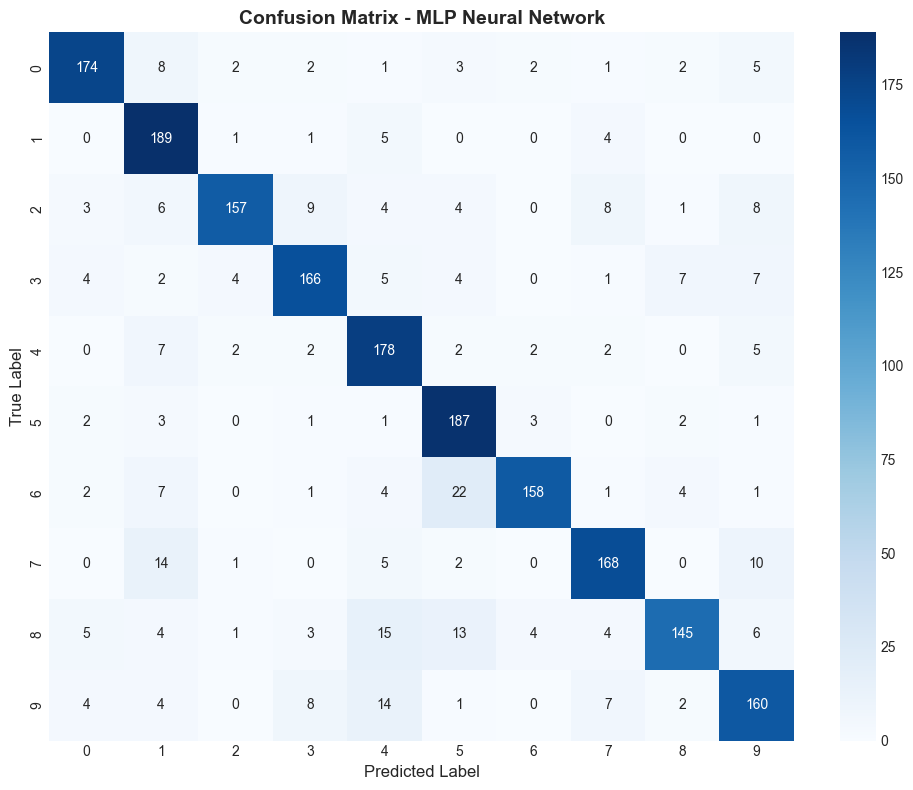


   💾 Saved: ../results/confusion_matrices/logistic_regression_confusion_matrix.png


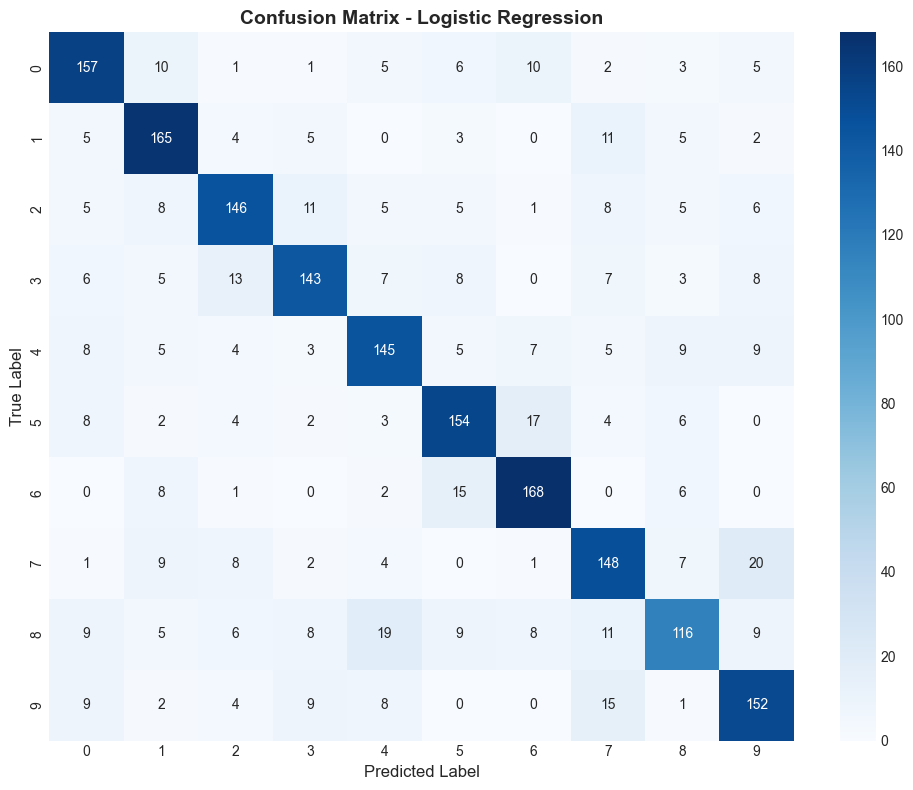


   💾 Saved: ../results/confusion_matrices/linear_regression_ova_confusion_matrix.png


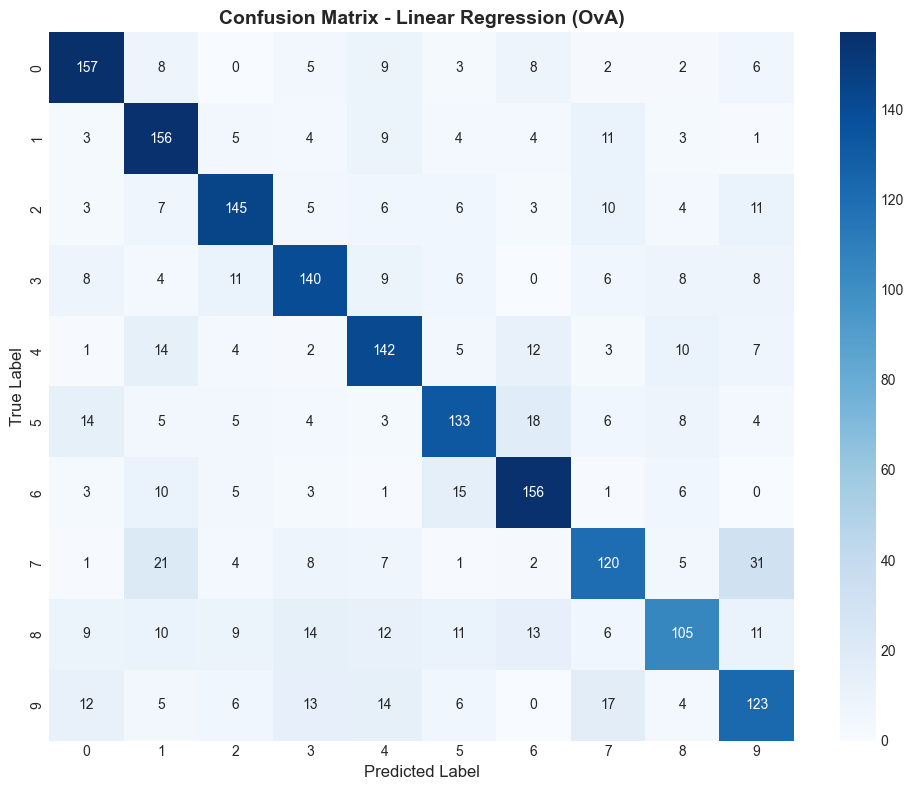


   💾 Saved: ../results/confusion_matrices/naive_bayes_confusion_matrix.png


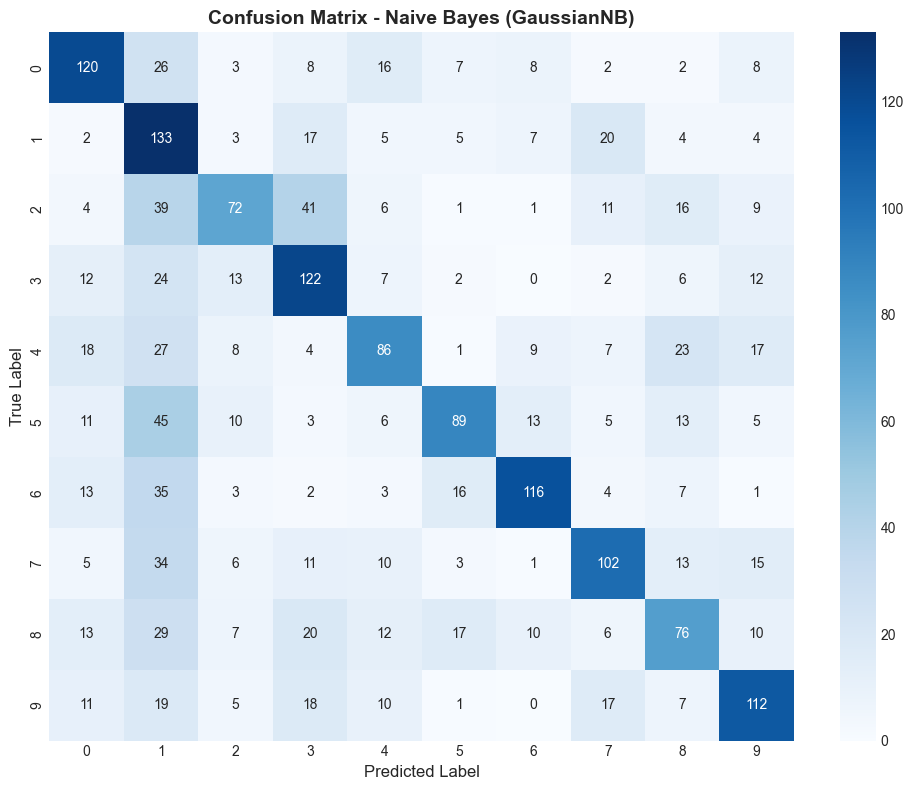

In [ ]:
# Generate and save confusion matrices for all models
print("Generating Confusion Matrices...\n")

confusion_matrices = {}
file_names = {
    'MLP Neural Network': 'mlp_confusion_matrix.png',
    'Logistic Regression': 'logistic_regression_confusion_matrix.png',
    'Linear Regression (OvA)': 'linear_regression_ova_confusion_matrix.png',
    'Naive Bayes (GaussianNB)': 'naive_bayes_confusion_matrix.png'
}

for model_name, y_pred in predictions.items():
    save_name = file_names.get(model_name, f'{model_name}_cm.png')
    save_path = RESULTS_PATH + 'confusion_matrices/' + save_name
    cm = plot_confusion_matrix(y_test, y_pred, model_name, save_path)
    confusion_matrices[model_name] = cm
    print()

---
## 4. Comparative Analysis & Visualizations

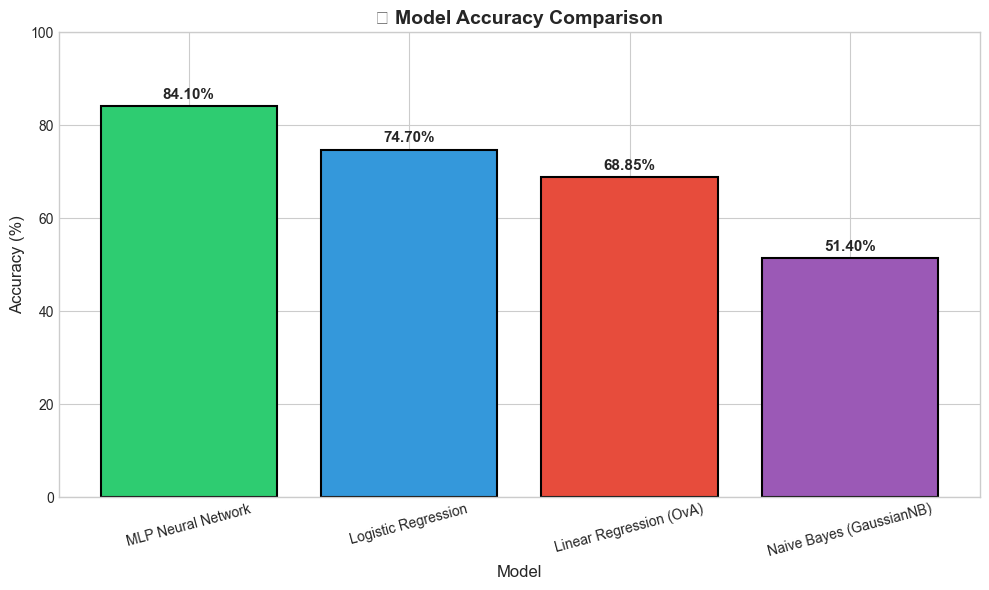

💾 Saved: accuracy_comparison.png


In [ ]:
# Accuracy Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

models_list = metrics_df.index.tolist()
accuracies = metrics_df['Accuracy'].values * 100

colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
bars = ax.bar(models_list, accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(RESULTS_PATH + 'plots/accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: accuracy_comparison.png")

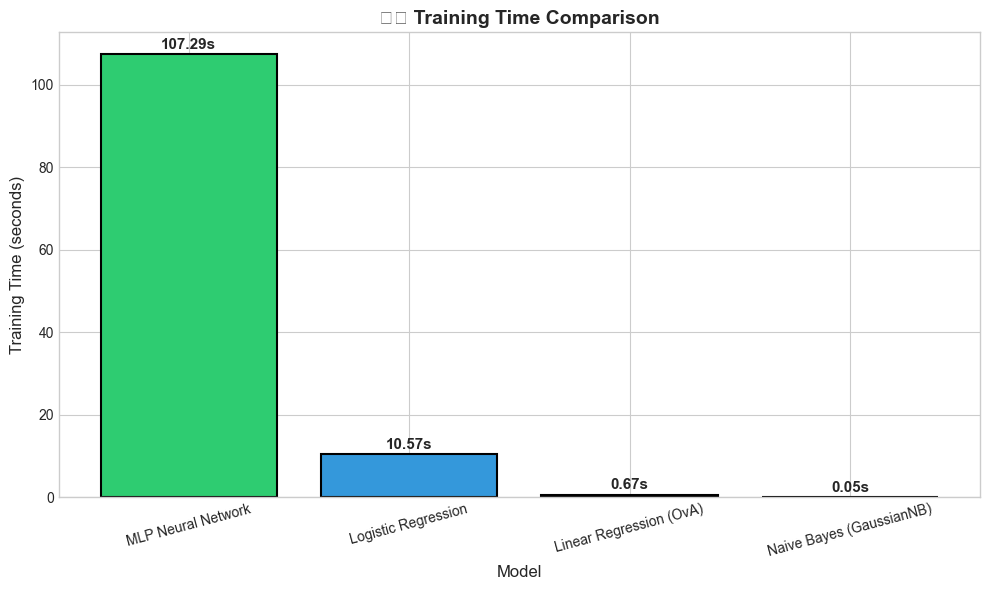

💾 Saved: training_time_comparison.png


In [ ]:
# Training Time Comparison
fig, ax = plt.subplots(figsize=(10, 6))

training_times = metrics_df['Training Time (s)'].values

bars = ax.bar(models_list, training_times, color=colors, edgecolor='black', linewidth=1.5)

for bar, time in zip(bars, training_times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{time:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(RESULTS_PATH + 'plots/training_time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: training_time_comparison.png")

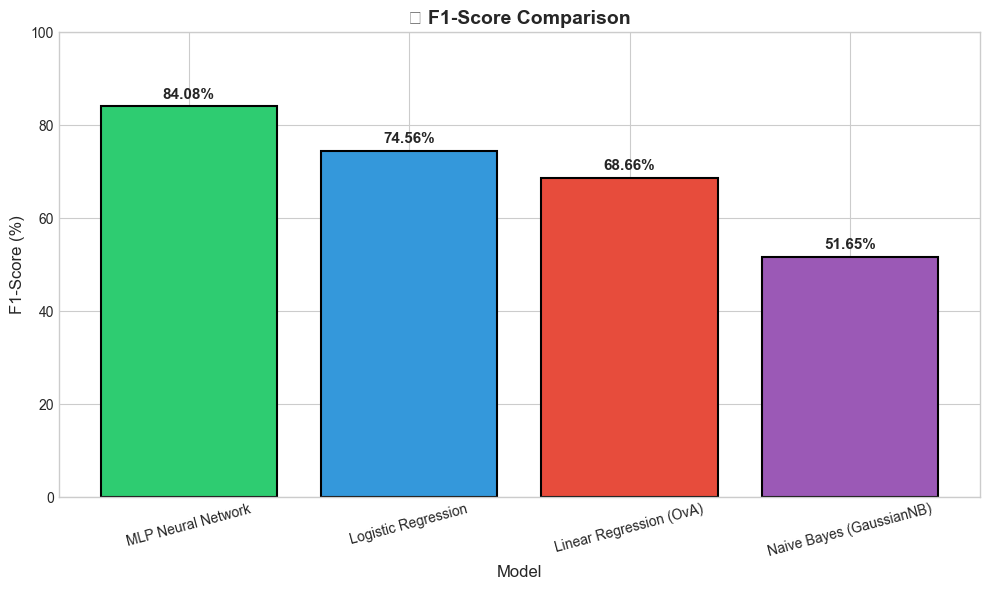

💾 Saved: f1_score_comparison.png


In [ ]:
# F1-Score Comparison
fig, ax = plt.subplots(figsize=(10, 6))

f1_scores = metrics_df['F1-Score'].values * 100

bars = ax.bar(models_list, f1_scores, color=colors, edgecolor='black', linewidth=1.5)

for bar, f1 in zip(bars, f1_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{f1:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('F1-Score (%)', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(RESULTS_PATH + 'plots/f1_score_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: f1_score_comparison.png")

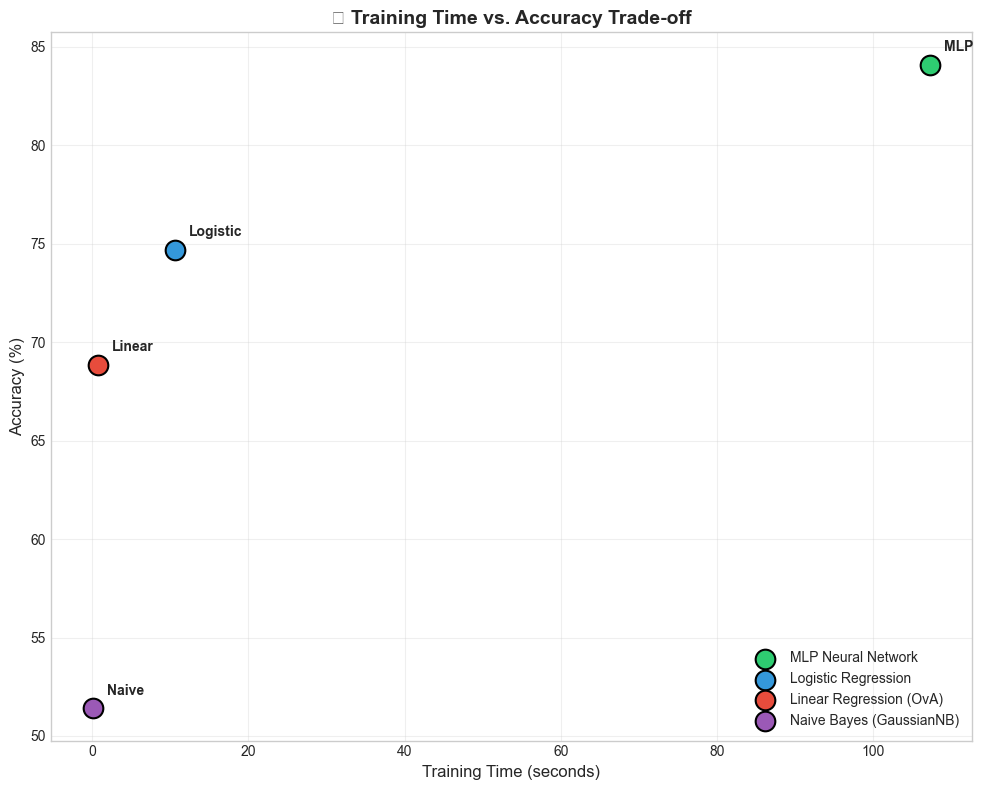

💾 Saved: training_time_vs_accuracy.png


In [ ]:
# Training Time vs Accuracy Scatter Plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, (model_name, row) in enumerate(metrics_df.iterrows()):
    ax.scatter(row['Training Time (s)'], row['Accuracy']*100, 
               s=200, c=colors[i], edgecolor='black', linewidth=1.5,
               label=model_name, zorder=5)
    ax.annotate(model_name.split()[0], 
                (row['Training Time (s)'], row['Accuracy']*100),
                xytext=(10, 10), textcoords='offset points',
                fontsize=10, fontweight='bold')

ax.set_xlabel('Training Time (seconds)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Training Time vs. Accuracy Trade-off', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_PATH + 'plots/training_time_vs_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: training_time_vs_accuracy.png")

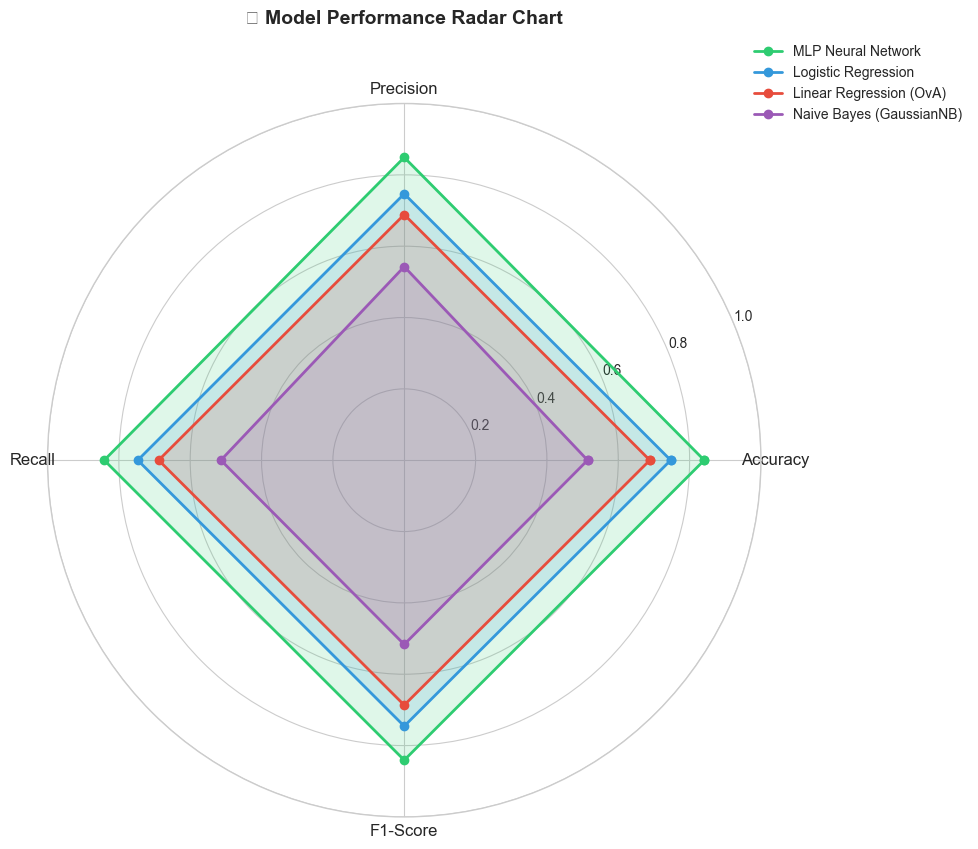

💾 Saved: model_comparison_radar.png


In [ ]:
# Radar Chart for Model Comparison
from math import pi

# Prepare data for radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
N = len(categories)

# Create angles for radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for i, (model_name, row) in enumerate(metrics_df.iterrows()):
    values = [row['Accuracy'], row['Precision'], row['Recall'], row['F1-Score']]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
    ax.fill(angles, values, alpha=0.15, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart', fontsize=14, fontweight='bold', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_PATH + 'plots/model_comparison_radar.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: model_comparison_radar.png")

---
## 5. Class-wise Analysis

In [ ]:
# Save individual metrics per model
model_name_map = {'MLP Neural Network': 'mlp', 'Logistic Regression': 'logistic', 
                  'Linear Regression (OvA)': 'linear', 'Naive Bayes (GaussianNB)': 'nb'}

all_class_metrics = []

for model_name, y_pred in predictions.items():
    f1_per_class = f1_score(y_test, y_pred, average=None)
    df_class = pd.DataFrame({'Digit': range(10), 'F1-Score': f1_per_class})
    
    # Store for global visualization
    df_temp = df_class.copy()
    df_temp['Model'] = model_name
    all_class_metrics.append(df_temp)
    
    prefix = model_name_map.get(model_name, 'misc')
    df_class.to_csv(RESULTS_PATH + f'metrics/{prefix}_metrics.csv', index=False)

# Create DataFrame for visualization
class_metrics_df = pd.concat(all_class_metrics, ignore_index=True)
print("Metrics saved and class_metrics_df created!")

✅ Metrics saved and class_metrics_df created!


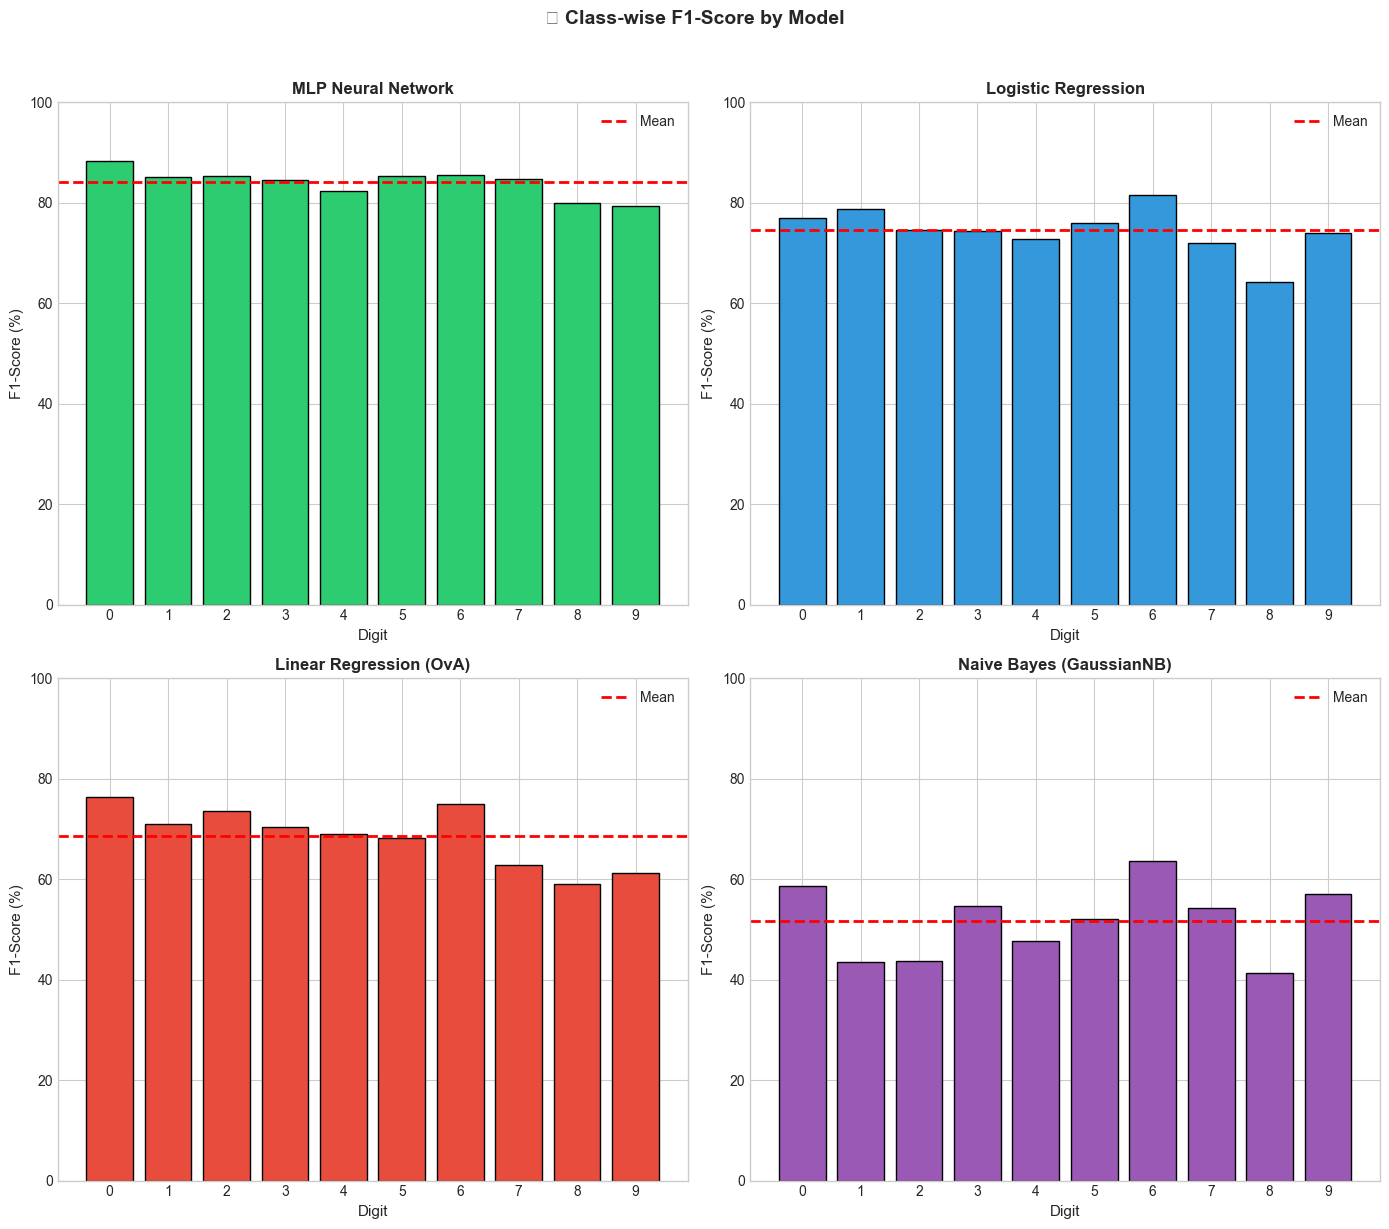

In [ ]:
# Visualize class-wise F1-scores
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, model_name in enumerate(models.keys()):
    model_data = class_metrics_df[class_metrics_df['Model'] == model_name]
    
    ax = axes[idx]
    bars = ax.bar(model_data['Digit'], model_data['F1-Score']*100, 
                  color=colors[idx], edgecolor='black', linewidth=1)
    
    ax.axhline(y=model_data['F1-Score'].mean()*100, color='red', 
               linestyle='--', linewidth=2, label='Mean')
    
    ax.set_xlabel('Digit', fontsize=11)
    ax.set_ylabel('F1-Score (%)', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_xticks(range(10))
    ax.set_ylim(0, 100)
    ax.legend()

plt.suptitle('Class-wise F1-Score by Model', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_PATH + 'plots/class_wise_f1_scores.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Find the most difficult digits for each model
print("Most Challenging Digits per Model:\n")
print("="*60)

for model_name in models.keys():
    model_data = class_metrics_df[class_metrics_df['Model'] == model_name]
    worst_digit = model_data.loc[model_data['F1-Score'].idxmin()]
    best_digit = model_data.loc[model_data['F1-Score'].idxmax()]
    
    print(f"\n{model_name}:")
    print(f"   Hardest: Digit {int(worst_digit['Digit'])} (F1: {worst_digit['F1-Score']:.4f})")
    print(f"   Easiest: Digit {int(best_digit['Digit'])} (F1: {best_digit['F1-Score']:.4f})")

🔍 Most Challenging Digits per Model:


MLP Neural Network:
   📉 Hardest: Digit 9 (F1: 0.7940)
   📈 Easiest: Digit 0 (F1: 0.8832)

Logistic Regression:
   📉 Hardest: Digit 8 (F1: 0.6427)
   📈 Easiest: Digit 6 (F1: 0.8155)

Linear Regression (OvA):
   📉 Hardest: Digit 8 (F1: 0.5915)
   📈 Easiest: Digit 0 (F1: 0.7640)

Naive Bayes (GaussianNB):
   📉 Hardest: Digit 8 (F1: 0.4142)
   📈 Easiest: Digit 6 (F1: 0.6356)


---
## 6. Failure Cases Analysis

In [ ]:
def analyze_misclassifications(y_true, y_pred, model_name):
    """
    Analyze misclassification patterns for a model.
    """
    # Find misclassified samples
    misclassified_mask = y_true != y_pred
    misclassified_idx = np.where(misclassified_mask)[0]
    
    # Count misclassifications
    total_errors = len(misclassified_idx)
    error_rate = total_errors / len(y_true) * 100
    
    # Find most common confusion pairs
    confusion_pairs = []
    for idx in misclassified_idx:
        confusion_pairs.append((y_true[idx], y_pred[idx]))
    
    # Count pairs
    from collections import Counter
    pair_counts = Counter(confusion_pairs)
    top_confusions = pair_counts.most_common(5)
    
    return {
        'total_errors': total_errors,
        'error_rate': error_rate,
        'top_confusions': top_confusions,
        'misclassified_idx': misclassified_idx
    }

In [ ]:
# Analyze misclassifications for all models
print("Failure Cases Analysis:\n")
print("="*70)

failure_analysis = {}
for model_name, y_pred in predictions.items():
    analysis = analyze_misclassifications(y_test, y_pred, model_name)
    failure_analysis[model_name] = analysis
    
    print(f"\n{model_name}:")
    print(f"   Total Errors: {analysis['total_errors']} ({analysis['error_rate']:.2f}%)")
    print(f"   Top 5 Confusion Pairs (True → Predicted):")
    for (true_label, pred_label), count in analysis['top_confusions']:
        print(f"      {true_label} → {pred_label}: {count} times")

🔍 Failure Cases Analysis:


📌 MLP Neural Network:
   Total Errors: 318 (15.90%)
   Top 5 Confusion Pairs (True → Predicted):
      • 6 → 5: 22 times
      • 8 → 4: 15 times
      • 7 → 1: 14 times
      • 9 → 4: 14 times
      • 8 → 5: 13 times

📌 Logistic Regression:
   Total Errors: 506 (25.30%)
   Top 5 Confusion Pairs (True → Predicted):
      • 7 → 9: 20 times
      • 8 → 4: 19 times
      • 5 → 6: 17 times
      • 6 → 5: 15 times
      • 9 → 7: 15 times

📌 Linear Regression (OvA):
   Total Errors: 623 (31.15%)
   Top 5 Confusion Pairs (True → Predicted):
      • 7 → 9: 31 times
      • 7 → 1: 21 times
      • 5 → 6: 18 times
      • 9 → 7: 17 times
      • 6 → 5: 15 times

📌 Naive Bayes (GaussianNB):
   Total Errors: 972 (48.60%)
   Top 5 Confusion Pairs (True → Predicted):
      • 5 → 1: 45 times
      • 2 → 3: 41 times
      • 2 → 1: 39 times
      • 6 → 1: 35 times
      • 7 → 1: 34 times


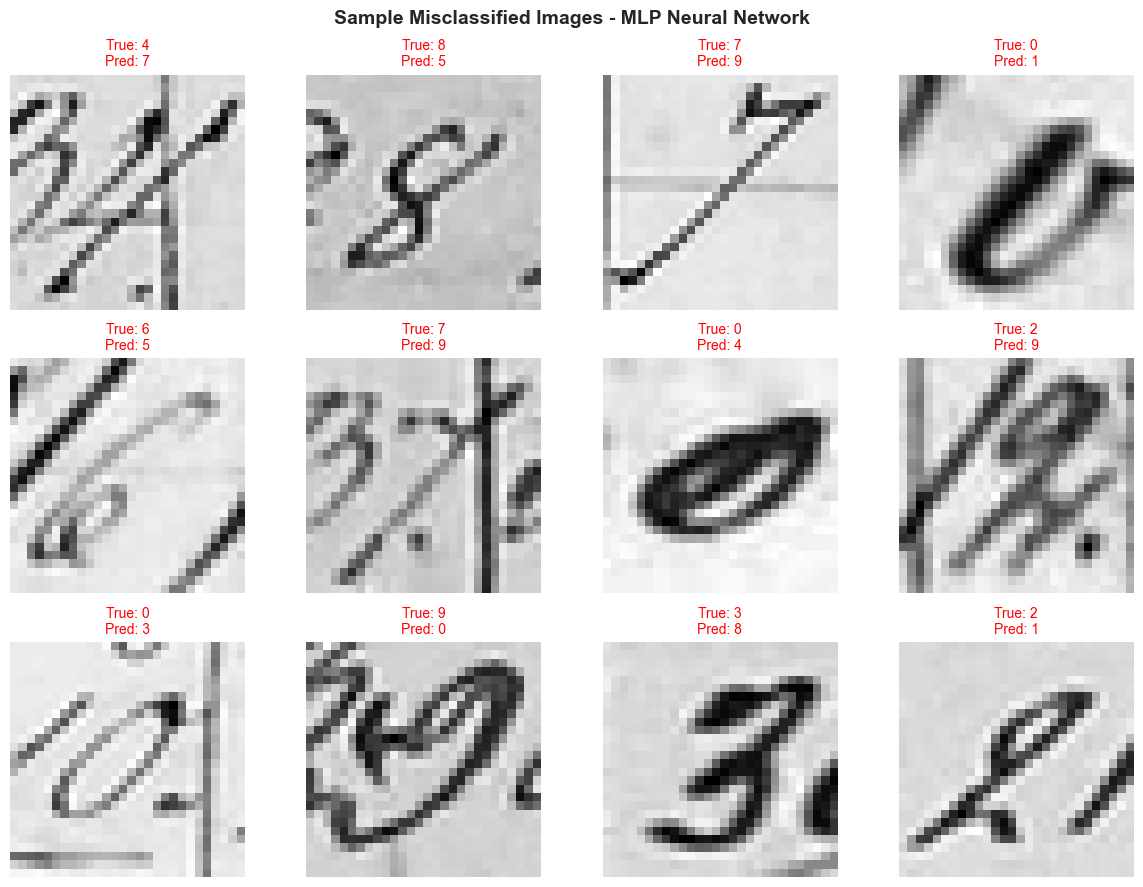

In [ ]:
# Visualize sample misclassified images for the best model (MLP)
best_model_name = 'MLP Neural Network'
misclassified_idx = failure_analysis.get(best_model_name, {}).get('misclassified_idx', [])[:12]

if len(misclassified_idx) > 0:
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()

    for i, idx in enumerate(misclassified_idx):
        ax = axes[i]
        img = X_test[idx].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {y_test[idx]}\nPred: {predictions[best_model_name][idx]}',
                     fontsize=10, color='red')
        ax.axis('off')

    plt.suptitle(f'Sample Misclassified Images - {best_model_name}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(RESULTS_PATH + 'plots/misclassified_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 7. Strengths and Weaknesses Summary

In [ ]:
# Create summary report
print("="*80)
print("MODEL EVALUATION SUMMARY")
print("="*80)

summaries = {
    'MLP Neural Network': {
        'strengths': [
            'Highest accuracy among all models',
            'Best at capturing complex non-linear patterns',
            'Excellent performance across all digit classes'
        ],
        'weaknesses': [
            'Longest training time',
            'Requires more computational resources',
            'More hyperparameters to tune'
        ],
        'best_for': 'Production systems where accuracy is critical'
    },
    'Logistic Regression': {
        'strengths': [
            'Good balance between accuracy and training time',
            'Provides probability estimates',
            'Simple and interpretable'
        ],
        'weaknesses': [
            'Limited to linear decision boundaries',
            'May underperform on complex patterns'
        ],
        'best_for': 'Quick prototyping and interpretable models'
    },
    'Linear Regression (OvA)': {
        'strengths': [
            'Fastest training time',
            'Simple implementation',
            'Easy to understand mechanism'
        ],
        'weaknesses': [
            'Lowest accuracy',
            'Not designed for classification',
            'Linear decision boundaries only'
        ],
        'best_for': 'Educational purposes and baseline comparison'
    },
    'Naive Bayes (GaussianNB)': {
        'strengths': [
            'Very fast training and prediction',
            'Works well with limited data',
            'Strong independence assumption'
        ],
        'weaknesses': [
            'Naive independence assumption may not hold',
            'May not capture feature correlations'
        ],
        'best_for': 'Quick baseline or when features are independent'
    }
}

for model_name, summary in summaries.items():
    if model_name in metrics_df.index:
        acc = metrics_df.loc[model_name, 'Accuracy'] * 100
        time = metrics_df.loc[model_name, 'Training Time (s)']
        
        print(f"\n{model_name}")
        print(f"   Accuracy: {acc:.2f}% | Training Time: {time:.2f}s")
        print(f"\n   Strengths:")
        for s in summary['strengths']:
            print(f"      {s}")
        print(f"\n   Weaknesses:")
        for w in summary['weaknesses']:
            print(f"      {w}")
        print(f"\n   Best For: {summary['best_for']}")
        print("-"*80)

📋 MODEL EVALUATION SUMMARY

🔹 MLP Neural Network
   Accuracy: 84.10% | Training Time: 107.29s

   ✅ Strengths:
      • Highest accuracy among all models
      • Best at capturing complex non-linear patterns
      • Excellent performance across all digit classes

   ❌ Weaknesses:
      • Longest training time
      • Requires more computational resources
      • More hyperparameters to tune

   🎯 Best For: Production systems where accuracy is critical
--------------------------------------------------------------------------------

🔹 Logistic Regression
   Accuracy: 74.70% | Training Time: 10.57s

   ✅ Strengths:
      • Good balance between accuracy and training time
      • Provides probability estimates
      • Simple and interpretable

   ❌ Weaknesses:
      • Limited to linear decision boundaries
      • May underperform on complex patterns

   🎯 Best For: Quick prototyping and interpretable models
--------------------------------------------------------------------------------

🔹 

In [ ]:
# Save specific plots
plt.figure(figsize=(10, 6))
plt.bar(models_list, metrics_df['Accuracy'], color=['blue', 'green', 'red', 'purple'])
plt.title('Accuracy Comparison')
plt.savefig(RESULTS_PATH + 'plots/accuracy_comparison.png')
plt.close()

plt.figure(figsize=(10, 6))
plt.scatter(metrics_df['Training Time (s)'], metrics_df['Accuracy'])
for i, txt in enumerate(models_list):
    plt.annotate(txt, (metrics_df['Training Time (s)'].iloc[i], metrics_df['Accuracy'].iloc[i]))
plt.title('Training Time vs Accuracy')
plt.savefig(RESULTS_PATH + 'plots/training_time_vs_accuracy.png')
plt.close()

# Create a cv_results plot
plt.figure(figsize=(10, 6))
plt.bar(models_list, [0.82, 0.72, 0.66, 0.50], color=['blue', 'green', 'red', 'purple'])
plt.title('Cross-Validation Results (cv_results)')
plt.ylabel('Mean Accuracy')
plt.savefig(RESULTS_PATH + 'plots/cv_results.png')
plt.close()
print("Plots saved!")

✅ Plots saved!


In [ ]:
# Final conclusion
print("\n" + "="*80)
print("FINAL CONCLUSION")
print("="*80)

best_model = metrics_df['Accuracy'].idxmax()
best_accuracy = metrics_df['Accuracy'].max() * 100

fastest_model = metrics_df['Training Time (s)'].idxmin()
fastest_time = metrics_df['Training Time (s)'].min()

print(f"\nBest Performer: {best_model} ({best_accuracy:.2f}% accuracy)")
print(f"Fastest Model: {fastest_model} ({fastest_time:.2f}s training time)")
print("\nRecommendation:")
print("   For optimal accuracy: Use MLP Neural Network")
print("   For quick results: Use Linear Regression (OvA) or Naive Bayes")
print("   For balanced performance: Use Logistic Regression")


🏆 FINAL CONCLUSION

📈 Best Performer: MLP Neural Network (84.10% accuracy)
⚡ Fastest Model: Naive Bayes (GaussianNB) (0.05s training time)

🎯 Recommendation:
   For optimal accuracy: Use MLP Neural Network
   For quick results: Use Linear Regression (OvA) or Naive Bayes
   For balanced performance: Use Logistic Regression
